In [1]:
from tensorflow import keras, optimizers
from tensorflow.keras.utils import to_categorical
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn import metrics
from tensorflow.keras import callbacks
import matplotlib.pyplot as plt

## Data

In [2]:
X = pd.read_csv("data/train_values.csv", index_col="building_id")
Y = pd.read_csv("data/train_labels.csv", index_col="building_id") - 1

# Y = to_categorical(Y, num_classes=3)

encoded_temp = pd.get_dummies(X["count_floors_pre_eq"], prefix="count_floors").astype(int)
X_encoded = pd.get_dummies(X, dtype=int).drop(columns="count_floors_pre_eq")
for temp_col in encoded_temp.columns:
    X_encoded[temp_col] = encoded_temp[temp_col]

X0 = X_encoded.copy(deep=True)
scaler = StandardScaler()
scaled_X0 = scaler.fit_transform(X0)

pca = PCA(n_components=10)
pca_X0 = pca.fit_transform(X0)

X0_train, X0_test, Y0_train, Y0_test = train_test_split(pca_X0, Y,test_size=0.2, random_state=192)


## Lượng thông tin sau khi PCA

In [18]:
pca.explained_variance_ratio_

array([9.86948084e-01, 1.26434940e-02, 4.01641950e-04, 4.78503106e-06,
       1.43830766e-06, 2.67727243e-07, 4.27717260e-08, 2.78110063e-08,
       2.54426635e-08, 2.15560196e-08])

In [3]:
corrs = X0.corr()
u,s,v = np.linalg.svd(corrs)
eig_values, eig_vectors = s, u

- Mất mát 65%

In [4]:
np.sum(eig_values[10:]) / np.sum(eig_values)

0.6594031508829913

- Giữ lại được 35%

In [5]:
np.sum(eig_values[:10]) / np.sum(eig_values)

0.3405968491170084

## Neural network


In [6]:
def gen_model(layers: list=[], input_shape: tuple=()):
    model = None
    if (len(layers) != 0):
        model = keras.models.Sequential(layers)
    else:
        model = keras.models.Sequential([
            keras.layers.Input(shape=input_shape),
            keras.layers.Dense(64, activation="relu"),
            keras.layers.Dense(64, activation="relu"),
            keras.layers.Dense(3, activation="softmax")
        ])

    model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["acc"])

    return model


model = gen_model(input_shape=(10,))


In [7]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │           704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,059 (19.76 KB)

 Trainable params: 5,059 (19.76 KB)

 Non-trainable params: 0 (0.00 B)

- early stop để quan sát giá trị loss sau mỗi epoch, nếu như 3 lần liên tiếp mà delta loss < 1e-3 thì dừng lại

In [8]:
early_stop = callbacks.EarlyStopping(monitor="loss", mode="min", min_delta=1e-5,patience=3, restore_best_weights=True, verbose=True)

- Model chỉ nhận tập label ở dạng one hot encode, nên dùng hàm to_categorical để convert
- Số epochs: 50
- Số sample trong mỗi batch (batch size): 6515
- Số step mỗi epoch: 32 step (32 batch mỗi epoch)

In [9]:
history = model.fit(X0_train, to_categorical(Y0_train), epochs=50, callbacks=[early_stop])

Epoch 1/50
6515/6515 ━━━━━━━━━━━━━━━━━━━━ 8s 943us/step - acc: 0.4564 - loss: 10.2781
Epoch 2/50
6515/6515 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step - acc: 0.4886 - loss: 2.8824
Epoch 3/50
6515/6515 ━━━━━━━━━━━━━━━━━━━━ 6s 962us/step - acc: 0.5112 - loss: 1.4478
Epoch 4/50
6515/6515 ━━━━━━━━━━━━━━━━━━━━ 6s 935us/step - acc: 0.5404 - loss: 1.0265
Epoch 5/50
6515/6515 ━━━━━━━━━━━━━━━━━━━━ 6s 892us/step - acc: 0.5629 - loss: 0.8684
Epoch 6/50
6515/6515 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step - acc: 0.5783 - loss: 0.8228
Epoch 7/50
6515/6515 ━━━━━━━━━━━━━━━━━━━━ 6s 916us/step - acc: 0.5816 - loss: 0.8168
Epoch 8/50
6515/6515 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step - acc: 0.5834 - loss: 0.8141
Epoch 9/50
6515/6515 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step - acc: 0.5823 - loss: 0.8099
Epoch 10/50
6515/6515 ━━━━━━━━━━━━━━━━━━━━ 6s 944us/step - acc: 0.5848 - loss: 0.8089
Epoch 11/50
6515/6515 ━━━━━━━━━━━━━━━━━━━━ 6s 992us/step - acc: 0.5873 - loss: 0.8068
Epoch 12/50
6515/6515 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step - acc: 0.5881 -

=> Điều kiện early stop nên model chỉ dừng ở 40 epochs và lấy bộ hệ số tốt nhất ở epoch 37

- Vẽ

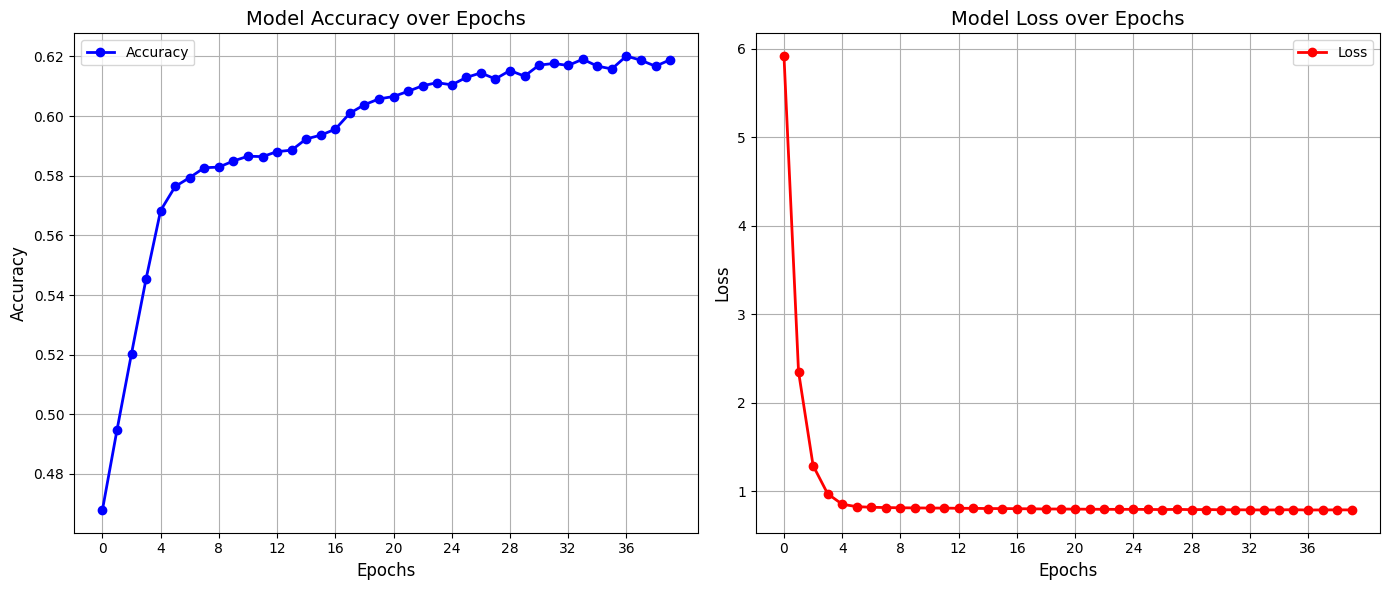

In [10]:
accs = history.history["acc"]
losses = history.history["loss"]

epochs = history.epoch


plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.plot(epochs, accs, color="blue", marker='o', linestyle='-', linewidth=2, markersize=6)
plt.title('Model Accuracy over Epochs', fontsize=14)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.grid(True)
plt.legend(['Accuracy'], loc='best')
plt.xticks(np.arange(min(epochs), max(epochs) + 1, 4))

plt.subplot(1, 2, 2)
plt.plot(epochs, losses, color="red", marker='o', linestyle='-', linewidth=2, markersize=6)
plt.title('Model Loss over Epochs', fontsize=14)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.grid(True)
plt.legend(['Loss'], loc='best')
plt.xticks(np.arange(min(epochs), max(epochs) + 1, 4))

plt.tight_layout()
plt.show()

- Sử dụng các giá trị softmax để đưa ra dự đoán (VD: [0.1, 0.3, 0.6] => predict: 2)

In [11]:
y_preds = np.array([np.argmax(pred) for pred in model.predict(X0_test)])
y_preds.shape

1629/1629 ━━━━━━━━━━━━━━━━━━━━ 2s 951us/step


(52121,)

In [12]:
print(metrics.classification_report(Y0_test, y_preds, digits=4))

              precision    recall  f1-score   support

           0     0.5411    0.4331    0.4812      5056
           1     0.6232    0.8734    0.7274     29611
           2     0.6777    0.2554    0.3710     17454

    accuracy                         0.6237     52121
   macro avg     0.6140    0.5207    0.5265     52121
weighted avg     0.6335    0.6237    0.5842     52121



[[ 2190  2751   115]
 [ 1744 25862  2005]
 [  113 12883  4458]]


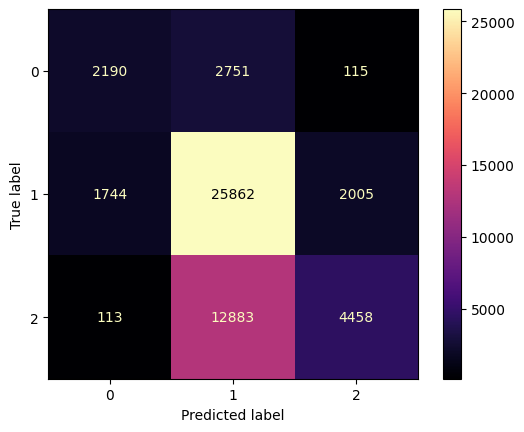

In [14]:
cm = metrics.confusion_matrix(Y0_test, y_preds)
metrics.ConfusionMatrixDisplay(cm).plot(cmap="magma")
print(cm)